In [83]:
from google.colab import drive

# This will prompt you to authorize access to your Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re



In [102]:
dataset = pd.read_csv("/content/drive/MyDrive/tour_logs_train.csv")


In [103]:
def fix_date(dataset):
  dataset["Show_DateTime"]= pd.to_datetime(dataset["Show_DateTime"],errors='coerce')
  if dataset["Show_DateTime"].isnull().any():
    dataset = dataset.dropna(subset=["Show_DateTime"])
  return dataset

In [104]:
dataset = fix_date(dataset)

In [106]:
def clean_price_simple(value):
  if pd.isna(value):
        return value
  text = str(value)
  clean_text = "".join(char for char in text if char.isdigit() or char == '.'or char=="£"or char=='€')
  return clean_text
dataset['Ticket_Price']= dataset["Ticket_Price"].apply(clean_price_simple)

def standardize_ticketprice(price):
  if pd.isna(price):
    if price <0 or price>100:
      return pd.NA
    else:
     price = price
     return price
  else:
    price_str = str(price)
    if '£' in price_str:

      price = float(price_str.replace('£',''))
      price = price * 1.27
      if price <0 or price>100:
        return pd.NA
      else:
        return price
    elif '€' in price_str:
      price = float(price_str.replace('€',''))
      price = price * 1.09

      if price <0 or price>100:
        return pd.NA
      else:
        return price
    else:
       try:
        return float(price)
       except :
        return pd.NA
dataset['Ticket_Price']=dataset['Ticket_Price'].apply(standardize_ticketprice)
dataset.dropna(inplace=True)

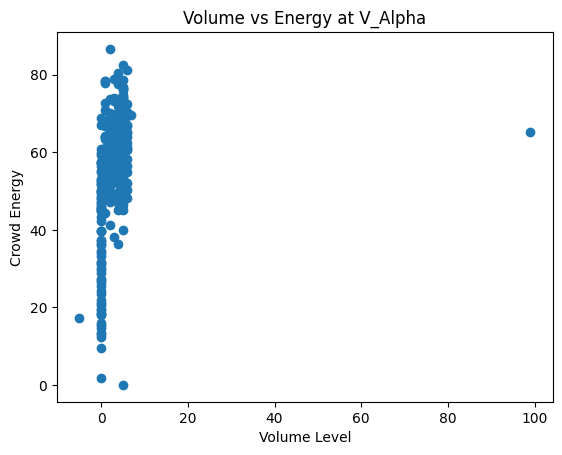

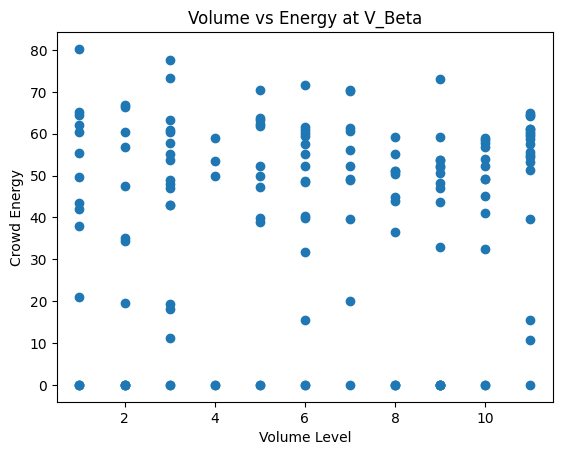

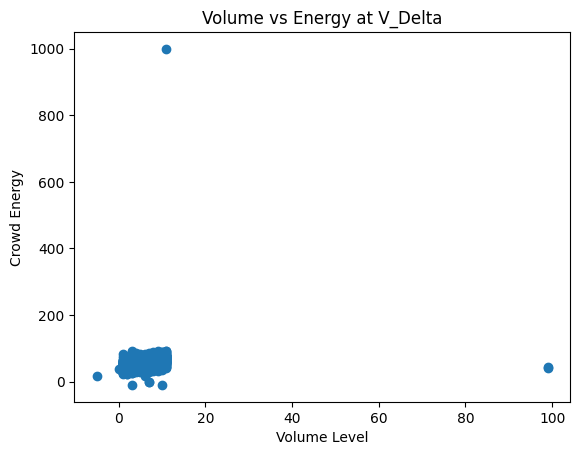

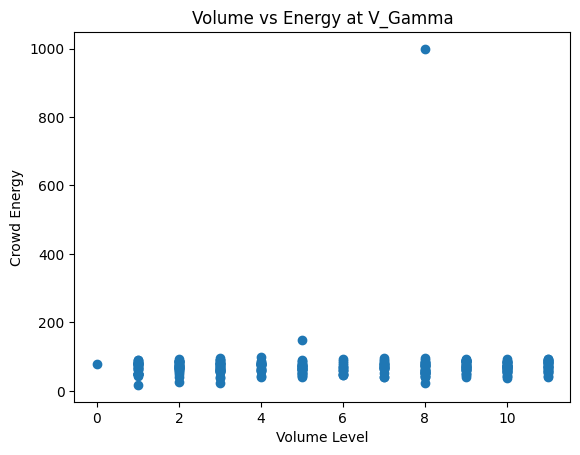

In [89]:
def plot_vol_energy(venue):
   sub = dataset[dataset['Venue_ID'] == venue]
   plt.scatter(sub['Volume_Level'], sub['Crowd_Energy'])
   plt.xlabel('Volume Level')
   plt.ylabel('Crowd Energy')
   plt.title(f'Volume vs Energy at {venue}')
   plt.show()
venues = dataset['Venue_ID'].unique()
for i in venues:
   plot_vol_energy(i)

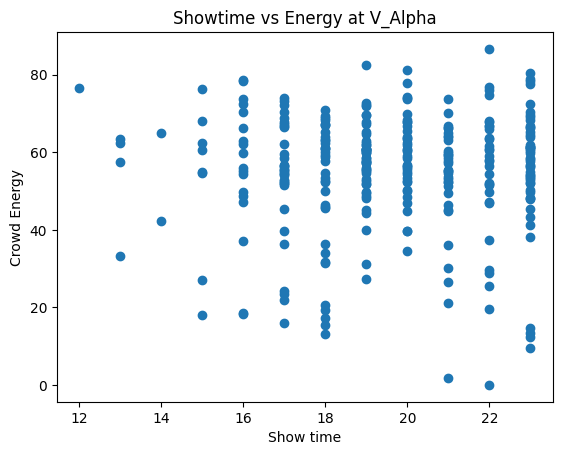

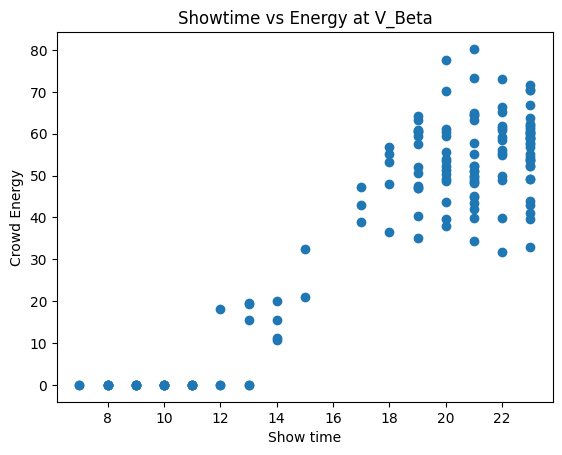

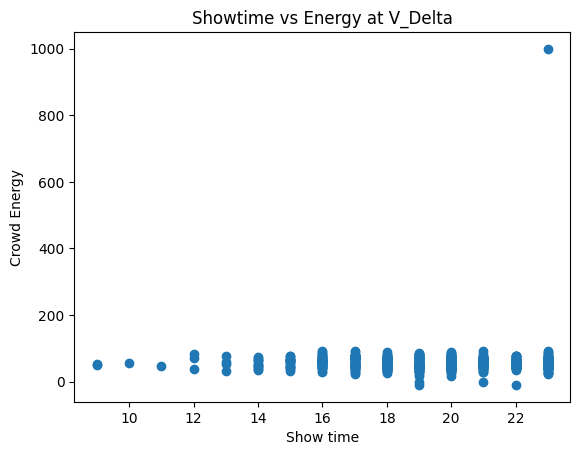

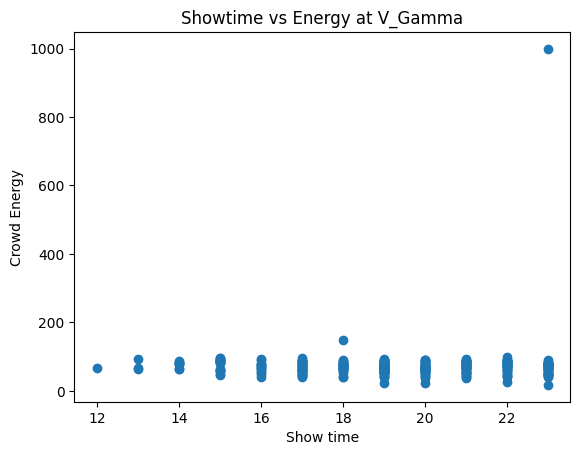

In [90]:
def plot_vol_energy(venue):
   sub = dataset[dataset['Venue_ID'] == venue].copy()
   sub["Time"]= sub["Show_DateTime"].dt.hour
   plt.scatter(sub['Time'], sub['Crowd_Energy'])
   plt.xlabel('Show time')
   plt.ylabel('Crowd Energy')
   plt.title(f'Showtime vs Energy at {venue}')
   plt.show()
venues = dataset['Venue_ID'].unique()
for i in venues:
   plot_vol_energy(i)


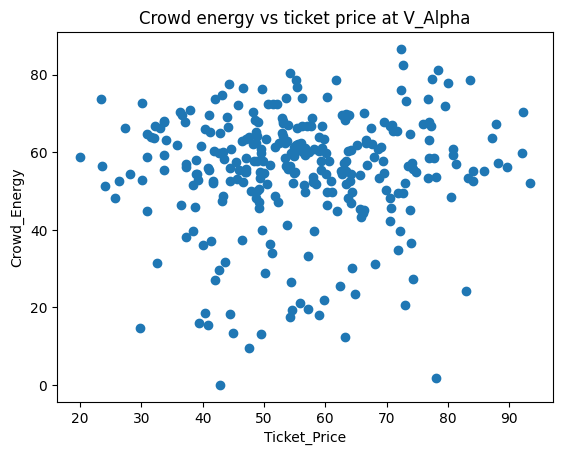

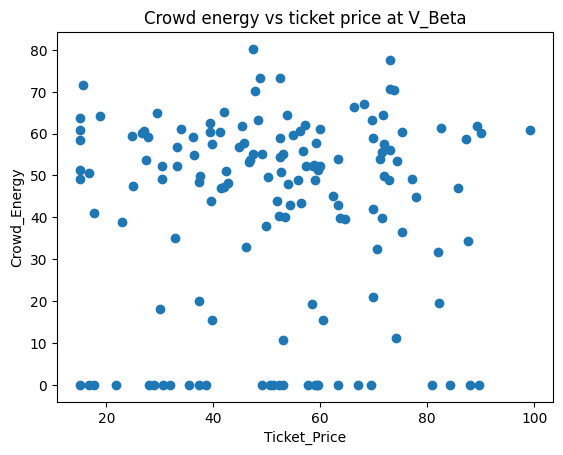

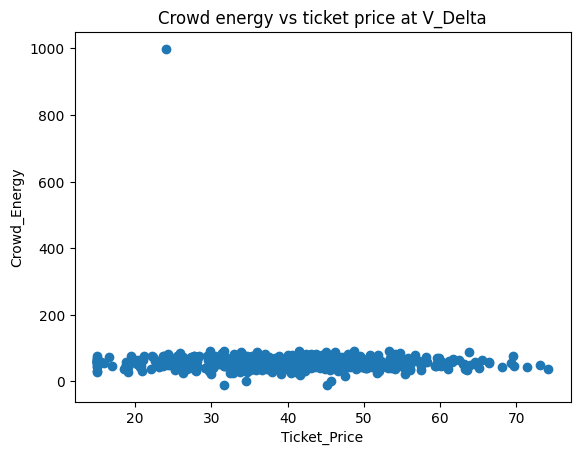

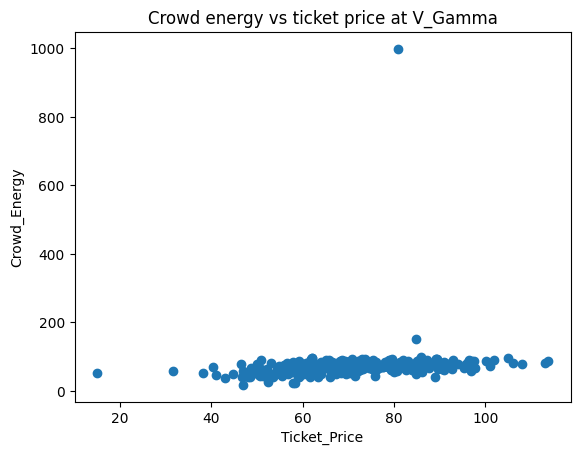

In [91]:
dataset['Ticket_Price']= dataset["Ticket_Price"].apply(clean_price_simple)
dataset['Ticket_Price']=dataset['Ticket_Price'].apply(standardize_ticketprice)
dataset.dropna(inplace=True)
def plot_price_energy(venue):
  sub2 = dataset[dataset["Venue_ID"]==venue]
  plt.scatter(sub2["Ticket_Price"],sub2["Crowd_Energy"])
  plt.xlabel("Ticket_Price")
  plt.ylabel("Crowd_Energy")
  plt.title(f"Crowd energy vs ticket price at {venue}")
  plt.show()
venues = dataset['Venue_ID'].unique()
for i in venues:
   plot_price_energy(i)


Day_of_Week
2    53.869941
4    54.200802
3    56.716190
1    56.907450
5    59.156129
0    62.211376
6    67.094033
Name: Crowd_Energy, dtype: float64


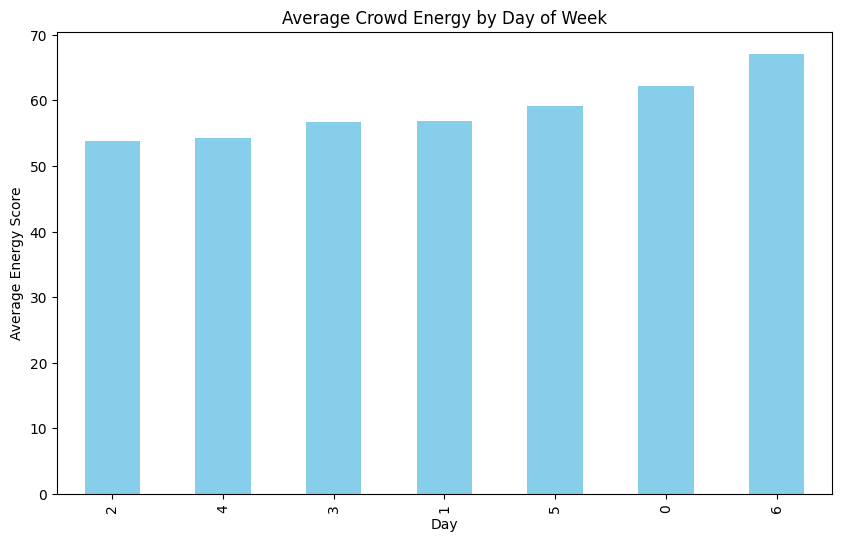

In [92]:
dataset['Day_Name'] = dataset['Show_DateTime'].dt.day_name().copy()
daily_energy = dataset.groupby('Day_of_Week')['Crowd_Energy'].mean().sort_values()
print(daily_energy)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

daily_energy.plot(kind='bar', color='skyblue')
plt.title('Average Crowd Energy by Day of Week')
plt.xlabel('Day')
plt.ylabel('Average Energy Score')
plt.show()

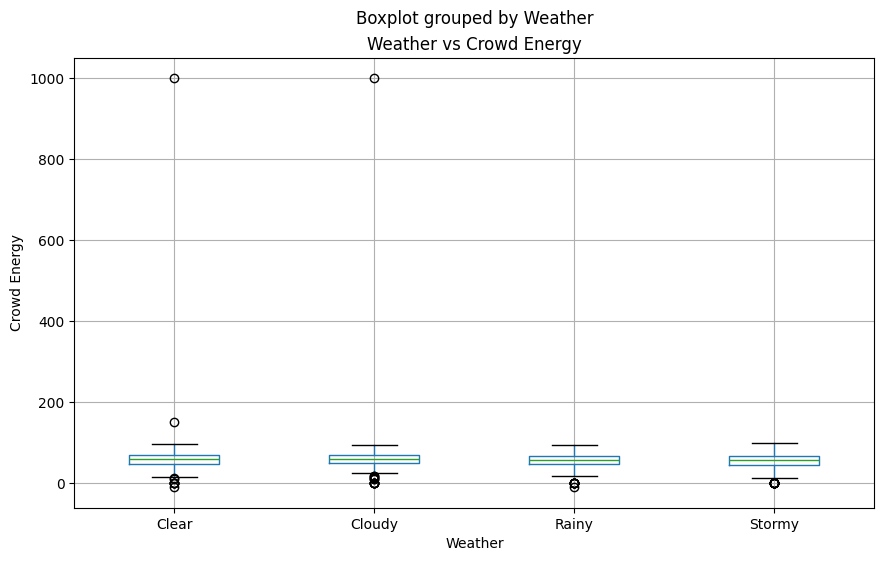

In [93]:
dataset.boxplot(column='Crowd_Energy', by='Weather', figsize=(10, 6))

plt.title('Weather vs Crowd Energy')

plt.ylabel('Crowd Energy')
plt.xlabel('Weather')
plt.show()

In [107]:
def fix_vol(df):
  df.loc[(df["Volume_Level"] < 0) | (df["Volume_Level"] > 100), "Volume_Level"] = pd.NA
  return df
def fix_energy(df):
  df.loc[(df["Crowd_Energy"] < 0) | (df["Crowd_Energy"] > 100), "Crowd_Energy"] = pd.NA
  return df
def fix_size(df):
  df.loc[df["Crowd_Size"] < 0, "Crowd_Size"] = pd.NA
  return df


dataset = fix_vol(dataset)
dataset = fix_energy(dataset)
dataset = fix_size(dataset)

dataset.dropna(inplace=True)

In [108]:
def feature_eng(df):
  df["Is_Weekend"]=df["Show_DateTime"].dt.dayofweek.isin([0,6]).astype(int)
  df["DayofWeek"]=df["Show_DateTime"].dt.day_name()
  df['Venue_Day_Combo'] = df['Venue_ID'] + "_" + df['Show_DateTime'].dt.day_name()

  months = df["Show_DateTime"].dt.month
  conditions = [
      months.isin([1, 2, 11, 12]),
      months.isin([3, 4]),
      months.isin([5, 6, 7])
  ]
  choices = ["Winter", "Spring", "Summer"]
  df["Season"] = np.select(conditions, choices, default="Autumn")
  df["Hour"]=df["Show_DateTime"].dt.hour
  df["Month"]=df["Show_DateTime"].dt.month

  return df


dataset['Show_DateTime'] = pd.to_datetime(dataset['Show_DateTime'], errors='coerce')
dataset.dropna(subset=['Show_DateTime'], inplace=True)
dataset = feature_eng(dataset)
column_to_move = dataset.pop("Crowd_Energy")
dataset["Crowd_Energy"] = column_to_move

dataset.drop(columns=["Show_DateTime", "Merch_Sales_Post_Show", "Gig_ID"], inplace=True)
print(dataset)

     Venue_ID  Day_of_Week  Volume_Level  Ticket_Price  Crowd_Size  \
0     V_Alpha            3           5.0         52.93       464.0   
1      V_Beta            3           2.0         66.33       388.0   
2     V_Delta            5           1.0         51.37       679.0   
4     V_Delta            4           8.0         47.34       654.0   
5     V_Alpha            2           3.0         69.63       320.0   
...       ...          ...           ...           ...         ...   
1988  V_Delta            0           6.0         49.11       583.0   
1989  V_Delta            1           9.0         48.09       497.0   
1990  V_Delta            4           8.0         24.36       550.0   
1992   V_Beta            4           4.0         52.40       633.0   
1999  V_Alpha            2           6.0         80.86       744.0   

      Opener_Rating Weather       Moon_Phase Band_Outfit  Is_Weekend  \
0                 2   Rainy  Waning Crescent     Leather           0   
1              

In [111]:
x = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

In [112]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


numeric_features = ['Ticket_Price', 'Crowd_Size', 'Day_of_Week', 'Volume_Level','Hour','Month','Opener_Rating']
categorical_features = ['Venue_ID', 'DayofWeek', 'Weather', 'Moon_Phase', 'Band_Outfit',"Season",'Venue_Day_Combo','Is_Weekend']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [143]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}


search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


print("Starting Grid Search for Random Forest...")
search.fit(x_train, y_train)


print("------------------------------------------------")
print(f"Best Parameters: {search.best_params_}")
print(f"Best RMSE Score: {-search.best_score_:.2f}")

best_rf_model = search.best_estimator_

Starting Grid Search for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
------------------------------------------------
Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best RMSE Score: 12.60


In [128]:
test = pd.read_csv("/content/drive/MyDrive/tour_logs_test_input.csv")


In [129]:
test = fix_date(test)
test["Ticket_Price"] =  test["Ticket_Price"].apply(clean_price_simple)
test["Ticket_Price"]= test["Ticket_Price"].apply(standardize_ticketprice)
test = fix_vol(test)

test = fix_size(test)

test.dropna(inplace=True)
test= feature_eng(test)
test['Show_DateTime'] = pd.to_datetime(test['Show_DateTime'], errors='coerce')
test.dropna(subset=['Show_DateTime'], inplace=True)
test = feature_eng(test)

test.drop(columns=["Show_DateTime", "Merch_Sales_Post_Show", "Gig_ID"], inplace=True)




In [130]:
x_1 = dataset.iloc[:,:-1]
y_1 = dataset.iloc[:,-1]

In [131]:
from sklearn.metrics import mean_squared_error
_
predictions = best_model.predict(x_1)
mse = mean_squared_error(y_1, predictions)
print(f"Final root Mean Squared Error: {mse**0.5}")


Final root Mean Squared Error: 10.074953078428996


In [146]:
import pandas as pd


predictions = search.predict(test)


id_list = [f"Gig_{i:04d}" for i in range(len(predictions))]


submission_df = pd.DataFrame({
    'Gig_ID': id_list,
    'Crowd_Energy': predictions
})


submission_df.to_csv('submission.csv', index=False)


print(submission_df.head())

     Gig_ID  Crowd_Energy
0  Gig_0000     63.595141
1  Gig_0001     61.818550
2  Gig_0002     47.535003
3  Gig_0003     31.912148
4  Gig_0004     58.376952


In [132]:
#BonusTask
df = dataset[dataset["Venue_ID"]=="V_Gamma"]

In [133]:
print(df)

     Venue_ID  Day_of_Week  Volume_Level  Ticket_Price  Crowd_Size  \
8     V_Gamma            1           8.0       48.0472       539.0   
12    V_Gamma            1          11.0       79.3100       441.0   
13    V_Gamma            3           4.0       48.4000       694.0   
16    V_Gamma            4           1.0       79.3900       339.0   
17    V_Gamma            1           5.0       73.2100       525.0   
...       ...          ...           ...           ...         ...   
1958  V_Gamma            6           4.0       95.8000       594.0   
1961  V_Gamma            1          10.0       76.2100       485.0   
1966  V_Gamma            3          11.0       71.0000       643.0   
1968  V_Gamma            4           9.0       52.5600       599.0   
1970  V_Gamma            3           6.0       63.5200       272.0   

      Opener_Rating Weather       Moon_Phase Band_Outfit  Is_Weekend  \
8                 5   Clear         New Moon     Leather           0   
12             

In [134]:
def pred_crowd(test_price): #assume attendance and ticket price are linearly related
  x,y=np.polyfit(df['Ticket_Price'],df['Crowd_Size'],1)
  return (x*test_price+y)


In [135]:
import numpy as np
def people_spend(df):
  base = 20

  spend = base*(1+0.0125*(df["Crowd_Energy"]-80))#
  return np.maximum(spend,5) #assuming people still spend bare minimum on drinks even if no energy

In [136]:

test_prices = np.arange(1, 100, 1)
test_df = pd.DataFrame({'Ticket_Price':test_prices})
test_df['Venue_ID'] = 'V_Gamma'
test_df['Day_of_Week'] = 5

test_df['Volume_Level'] = 5.0
test_df['Weather'] = 'Clear'
test_df['Moon_Phase'] = 'Full Moon'
test_df['Band_Outfit'] = 'Leather'
test_df['Is_Weekend']=0
test_df['Season']='Summer'
test_df['Hour']='18'
test_df['Month']=4
test_df['Venue_Day_Combo']='V_Gamma_Friday'
test_df['Opener_Rating']=7
test_df["DayofWeek"]='Friday'
test_df["Crowd_Size"]=test_df["Ticket_Price"].apply(pred_crowd)
test_df["Crowd_Energy"]=search.predict(test_df)
print(test_df)


    Ticket_Price Venue_ID  Day_of_Week  Volume_Level Weather Moon_Phase  \
0              1  V_Gamma            5           5.0   Clear  Full Moon   
1              2  V_Gamma            5           5.0   Clear  Full Moon   
2              3  V_Gamma            5           5.0   Clear  Full Moon   
3              4  V_Gamma            5           5.0   Clear  Full Moon   
4              5  V_Gamma            5           5.0   Clear  Full Moon   
..           ...      ...          ...           ...     ...        ...   
94            95  V_Gamma            5           5.0   Clear  Full Moon   
95            96  V_Gamma            5           5.0   Clear  Full Moon   
96            97  V_Gamma            5           5.0   Clear  Full Moon   
97            98  V_Gamma            5           5.0   Clear  Full Moon   
98            99  V_Gamma            5           5.0   Clear  Full Moon   

   Band_Outfit  Is_Weekend  Season Hour  Month Venue_Day_Combo  Opener_Rating  \
0      Leather    

In [138]:
test_df["spend"]=people_spend(test_df)
print (test_df)

    Ticket_Price Venue_ID  Day_of_Week  Volume_Level Weather Moon_Phase  \
0              1  V_Gamma            5           5.0   Clear  Full Moon   
1              2  V_Gamma            5           5.0   Clear  Full Moon   
2              3  V_Gamma            5           5.0   Clear  Full Moon   
3              4  V_Gamma            5           5.0   Clear  Full Moon   
4              5  V_Gamma            5           5.0   Clear  Full Moon   
..           ...      ...          ...           ...     ...        ...   
94            95  V_Gamma            5           5.0   Clear  Full Moon   
95            96  V_Gamma            5           5.0   Clear  Full Moon   
96            97  V_Gamma            5           5.0   Clear  Full Moon   
97            98  V_Gamma            5           5.0   Clear  Full Moon   
98            99  V_Gamma            5           5.0   Clear  Full Moon   

   Band_Outfit  Is_Weekend  Season Hour  Month Venue_Day_Combo  Opener_Rating  \
0      Leather    

profit = ticket price * attendance + (per person spend)* attendance - 5000-8*attendance

In [139]:
test_df["costs"]= 5000 +(8*test_df['Crowd_Size'])
test_df['earn']=test_df['spend']+ test_df["Crowd_Size"]*test_df["Ticket_Price"]
test_df["profit"]=test_df["earn"]-test_df["spend"]
print(test_df)

    Ticket_Price Venue_ID  Day_of_Week  Volume_Level Weather Moon_Phase  \
0              1  V_Gamma            5           5.0   Clear  Full Moon   
1              2  V_Gamma            5           5.0   Clear  Full Moon   
2              3  V_Gamma            5           5.0   Clear  Full Moon   
3              4  V_Gamma            5           5.0   Clear  Full Moon   
4              5  V_Gamma            5           5.0   Clear  Full Moon   
..           ...      ...          ...           ...     ...        ...   
94            95  V_Gamma            5           5.0   Clear  Full Moon   
95            96  V_Gamma            5           5.0   Clear  Full Moon   
96            97  V_Gamma            5           5.0   Clear  Full Moon   
97            98  V_Gamma            5           5.0   Clear  Full Moon   
98            99  V_Gamma            5           5.0   Clear  Full Moon   

   Band_Outfit  Is_Weekend  Season Hour  Month Venue_Day_Combo  Opener_Rating  \
0      Leather    

/tmp/ipython-input-3638532019.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


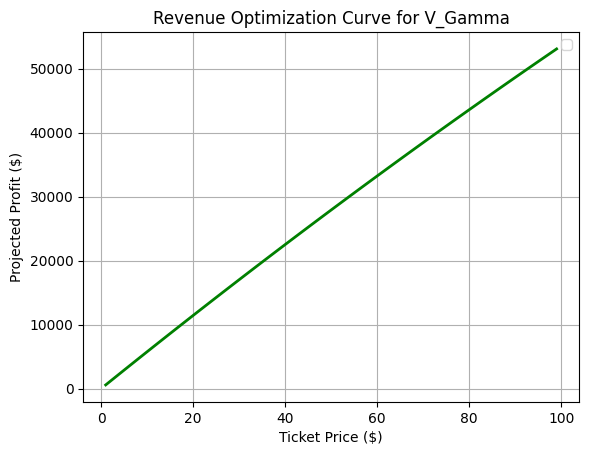

In [140]:
plt.plot(test_df['Ticket_Price'], test_df['profit'], color='green', linewidth=2)

plt.title("Revenue Optimization Curve for V_Gamma")
plt.xlabel("Ticket Price ($)")
plt.ylabel("Projected Profit ($)")
plt.legend()
plt.grid(True)
plt.show()

In [141]:
opt_index = test_df['profit'].idxmax()
opt_scenario = test_df.loc[opt_index]
opt_price = opt_scenario['Ticket_Price']
max_profit = opt_scenario['profit']
print(f"optimal price {opt_price}")



optimal price 99


In [145]:
from google.colab import files


files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>